In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Cambiamos al directorio donde está el archivo CSV
os.chdir(r'C:\Users\frank\OneDrive\Desktop\Analista de Datos\Python\ArchivosCsv')

# Leemos el archivo CSV
df = pd.read_csv('fifa_eda.csv')

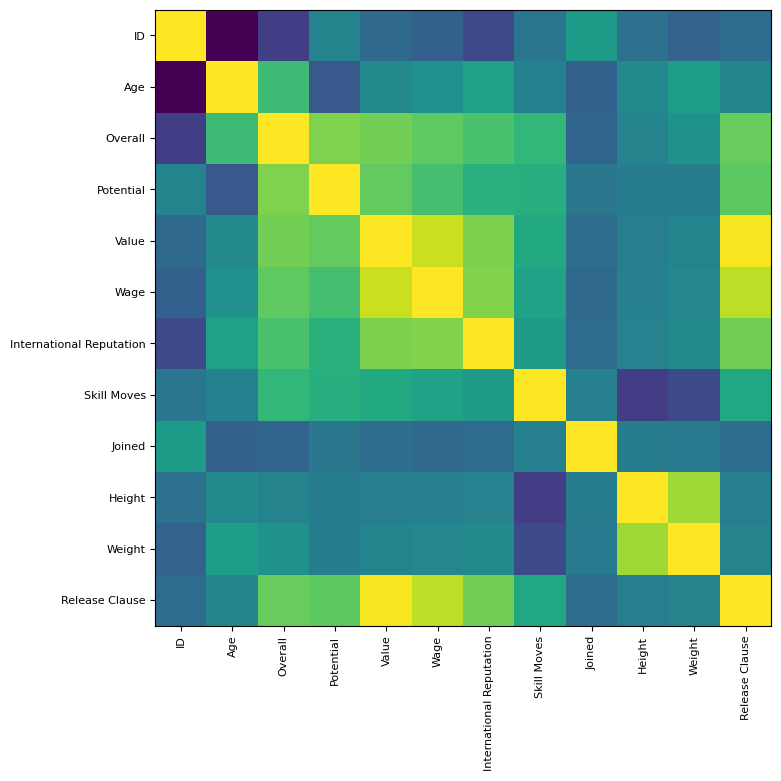

In [ ]:
#Elemento 1: Obtener matriz de correlación y dejarla como heat map

# 1) Nos quedamos con columnas numéricas
num_df = df.select_dtypes(include=[np.number])

# (opcional) Si hay muchas columnas, puedes quedarte con las primeras N
num_df = num_df.iloc[:, :10]  # Se hicieron cambios primeras 100 factor columnas numéricas


# 2) Calculamos la correlación
corr = num_df.corr(numeric_only=True)

# 3) Heatmap con matplotlib (sin estilos/colores personalizados)
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(corr.values)  # usa el colormap por defecto

# Ejes y etiquetas
ax.set_xticks(range(len(corr.columns)))
ax.set_yticks(range(len(corr.index)))
ax.set_xticklabels(corr.columns, rotation=90, fontsize=8)
ax.set_yticklabels(corr.index, fontsize=8)

# Mostrar y guardar
plt.show()
#fig.savefig("correlacion_heatmap.png", dpi=150, bbox_inches="tight")

# (opcional) Guardar la matriz
#corr.round(5).to_csv("correlacion_matrix.csv")

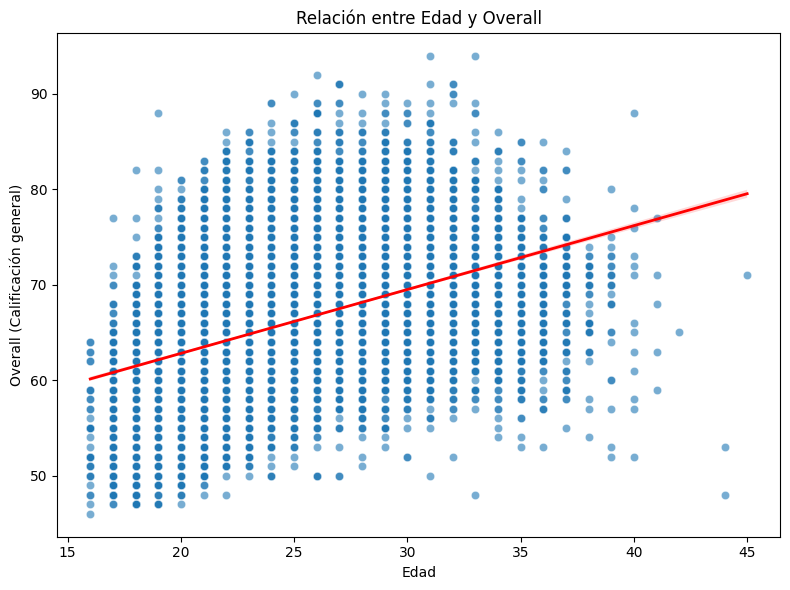

In [12]:
# --- ELEMENTO 2: Relación entre Edad y Overall ---
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Scatter plot: relación entre edad y nivel general (overall)
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='Age', y='Overall', alpha=0.6)

# 2) Línea de tendencia
sns.regplot(data=df, x='Age', y='Overall', scatter=False, color='red', line_kws={"linewidth":2})

plt.title("Relación entre Edad y Overall")
plt.xlabel("Edad")
plt.ylabel("Overall (Calificación general)")
plt.tight_layout()
plt.show()

,Club,Jugadores únicos
0,Manchester United,33
1,Arsenal,33
2,Newcastle United,33
3,Liverpool,33
4,Real Madrid,33
...,...,...
646,Internacional,20
647,América FC (Minas Gerais),20
648,Sligo Rovers,19
649,Limerick FC,19


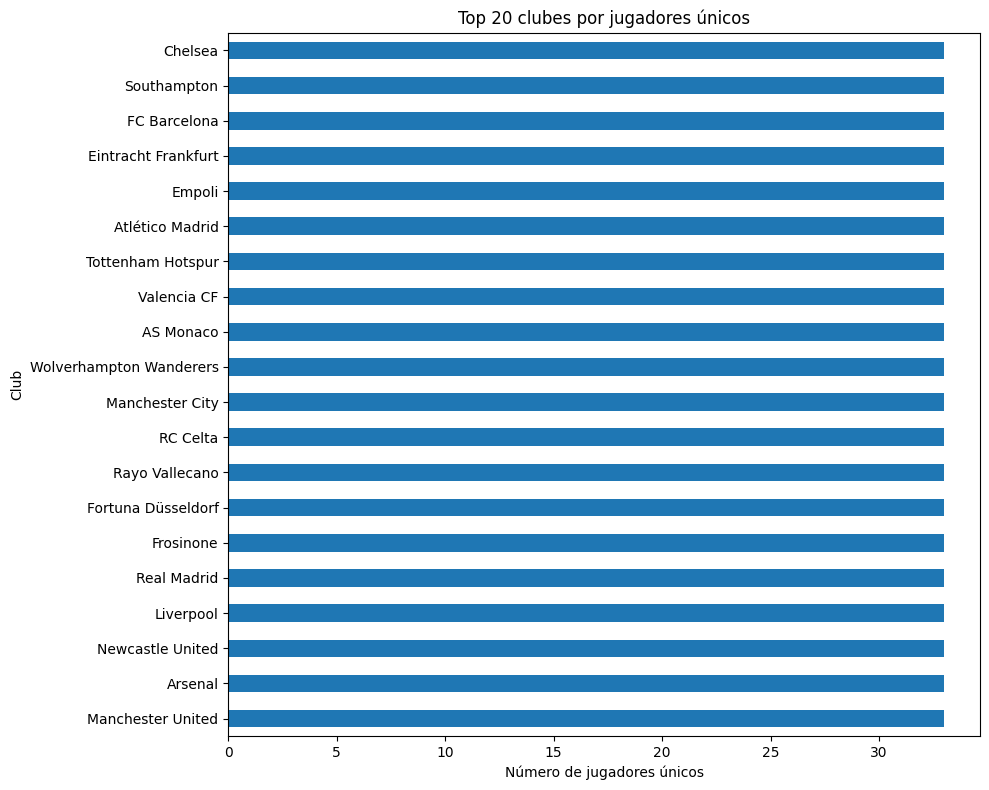

In [13]:
# Si tu dataset tiene una columna 'ID' única por jugador:
tmp = (
    df[['Club','ID']]
    .dropna(subset=['Club','ID'])
    .assign(Club=lambda x: x['Club'].astype(str).str.strip())
)

club_counts_unique = tmp.groupby('Club')['ID'].nunique().sort_values(ascending=False)

display(pd.DataFrame({'Club': club_counts_unique.index, 'Jugadores únicos': club_counts_unique.values}))

fig, ax = plt.subplots(figsize=(10, 8))
club_counts_unique.head(20).sort_values(ascending=True).plot(kind='barh', ax=ax)

ax.set_title("Top 20 clubes por jugadores únicos")
ax.set_xlabel("Número de jugadores únicos")
ax.set_ylabel("Club")
plt.tight_layout()
plt.show()

fig.savefig("clubes_jugadores_unicos_top20.png", dpi=150, bbox_inches="tight")
club_counts_unique.to_csv("clubes_jugadores_unicos.csv", header=['jugadores_unicos'])


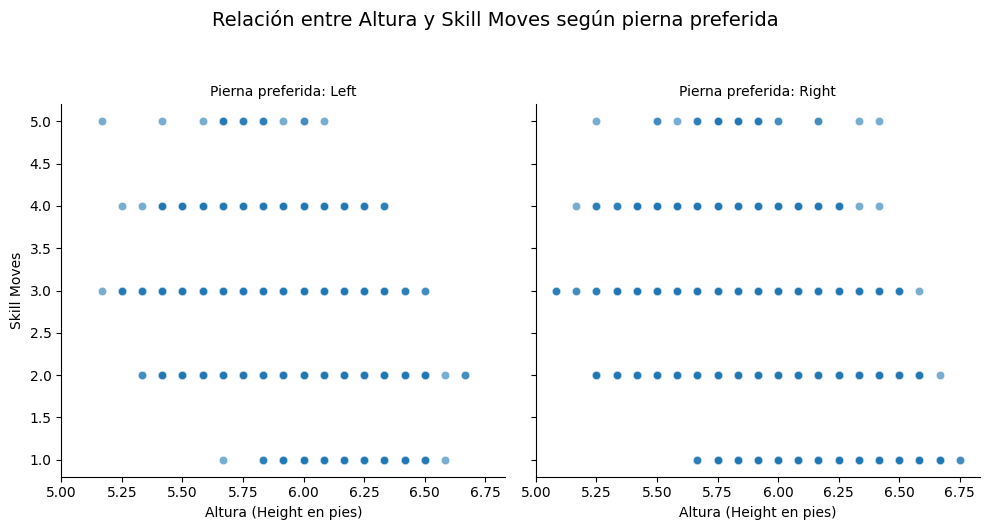

In [14]:
# --- ELEMENTO 4: Gráfico multipanel (Height vs Skill Moves, separado por pierna preferida) ---
import seaborn as sns
import matplotlib.pyplot as plt

# Limpiamos datos relevantes
subset = df[['Height', 'Skill Moves', 'Preferred Foot']].dropna()
subset['Preferred Foot'] = subset['Preferred Foot'].astype(str).str.strip()

# Creamos el gráfico multipanel (facet grid)
g = sns.FacetGrid(subset, col="Preferred Foot", height=5, aspect=1)
g.map_dataframe(sns.scatterplot, x="Height", y="Skill Moves", alpha=0.6)

# Ajustamos títulos y etiquetas
g.set_axis_labels("Altura (Height en pies)", "Skill Moves")
g.set_titles(col_template="Pierna preferida: {col_name}")
plt.suptitle("Relación entre Altura y Skill Moves según pierna preferida", fontsize=14, y=1.05)
plt.tight_layout()
plt.show()

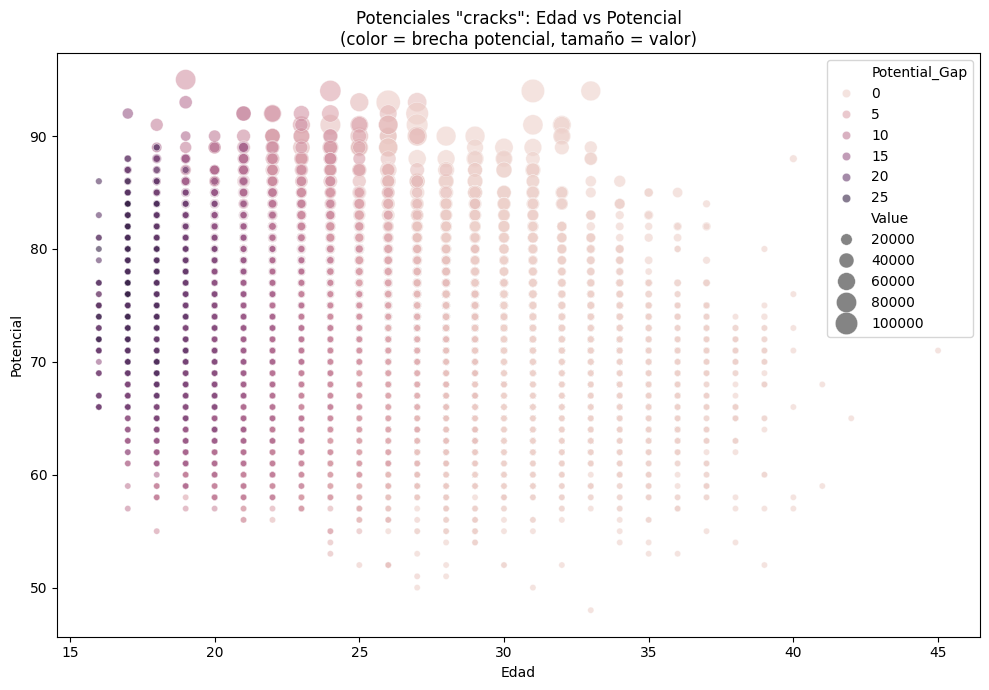

,Name,Age,Overall,Potential,Value,Club,Position,Potential_Gap
25,K. Mbappé,19,88,95,81000.0,Paris Saint-Germain,RM,7
229,G. Donnarumma,19,82,93,29000.0,Milan,GK,11
1143,Vinícius Júnior,17,77,92,17500.0,Real Madrid,LW,15
156,Gabriel Jesus,21,83,92,41000.0,Manchester City,ST,9
155,O. Dembélé,21,83,92,40000.0,FC Barcelona,RW,9
79,Marco Asensio,22,85,92,54000.0,Real Madrid,RW,7
77,M. Škriniar,23,85,92,46500.0,Inter,LCB,7
55,L. Sané,22,86,92,61000.0,Manchester City,LW,6
226,M. de Ligt,18,82,91,27000.0,Ajax,RCB,9
177,Kepa,23,83,91,28500.0,Chelsea,GK,8


In [15]:
# --- ELEMENTO 5: Detección visual de "potenciales cracks" ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Preparación de datos
cols = ['Name','Age','Overall','Potential','Value','Club','Position']
sub = df[cols].dropna().copy()

# Asegúrate de que Value sea numérico (si viniera como string en otros datasets)
# sub['Value'] = (sub['Value'].replace({r'[^0-9.]': ''}, regex=True).astype(float))

# Métrica clave: brecha de potencial (cuánto puede crecer)
sub['Potential_Gap'] = sub['Potential'] - sub['Overall']

# 2) Scatter/burbujas: Edad vs Potencial
plt.figure(figsize=(10, 7))
ax = sns.scatterplot(
    data=sub, x='Age', y='Potential',
    hue='Potential_Gap',            # color = margen de crecimiento
    size='Value', sizes=(20, 300),  # burbuja = valor de mercado
    alpha=0.6, legend='brief'
)

plt.title('Potenciales "cracks": Edad vs Potencial\n(color = brecha potencial, tamaño = valor)')
plt.xlabel('Edad')
plt.ylabel('Potencial')
plt.tight_layout()
plt.show()

# 3) (Opcional) Tabla de candidatos: jóvenes, alto potencial y buena brecha
candidatos = (
    sub[(sub['Age'] <= 23) & (sub['Potential'] >= 85) & (sub['Potential_Gap'] >= 2)]
    .sort_values(['Potential','Potential_Gap','Value'], ascending=[False, False, False])
)
display(candidatos.head(15))

# 4) Guardados opcionales
candidatos.to_csv('potenciales_cracks_top15.csv', index=False)
plt.figure(figsize=(10, 7))
ax = sns.scatterplot(
    data=sub, x='Age', y='Potential',
    hue='Potential_Gap', size='Value', sizes=(20, 300), alpha=0.6, legend=False
)
plt.title('Potenciales "cracks": Edad vs Potencial')
plt.xlabel('Edad'); plt.ylabel('Potencial'); plt.tight_layout()
plt.savefig('potenciales_cracks_scatter.png', dpi=150, bbox_inches='tight')
plt.close()
